In [1]:
# Training deep autoencoder for collaborative filtering

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

## Read Dataset

In [3]:
df = pd.read_csv('../data/ml-latest-small/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


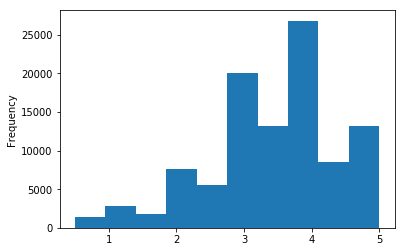

In [314]:
df_train.rating.plot(kind='hist')

In [4]:
df_user_idx = df[['userId']].drop_duplicates().reset_index(drop=True)\
                .reset_index().rename(columns={'index': 'userId_idx'})
df_user_idx.shape

(610, 2)

In [5]:
df_user_idx.head()

,userId_idx,userId
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5


In [6]:
df_movie_idx = df[['movieId']].drop_duplicates().reset_index(drop=True)\
                    .reset_index().rename(columns={'index': 'movieId_idx'})
df_movie_idx.shape

(9724, 2)

In [7]:
df_movie_idx.head()

,movieId_idx,movieId
0,0,1
1,1,3
2,2,6
3,3,47
4,4,50


### Preparate Train Dataset

In [8]:
from scipy.sparse.csr import csr_matrix
from scipy.sparse import save_npz, load_npz


In [309]:
df_train = df#.groupby('userId').agg({'movieId': lambda x: list(x), 'rating': lambda x: list(x)})

# Merge Dataset
df_train = df_train.merge(
                df_user_idx, on='userId', how='inner')\
            .merge(
                df_movie_idx, on='movieId', how='inner')


df_train.head()

,userId,movieId,rating,timestamp,userId_idx,movieId_idx
0,1,1,4.0,964982703,0,0
1,5,1,4.0,847434962,4,0
2,7,1,4.5,1106635946,6,0
3,15,1,2.5,1510577970,14,0
4,17,1,4.5,1305696483,16,0


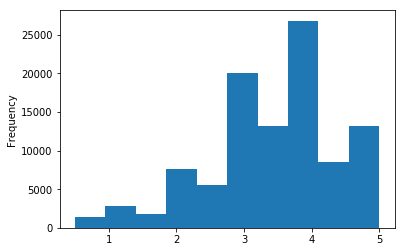

In [313]:
df_train.rating.plot(kind='hist')

In [10]:
df.groupby('userId').agg({'movieId': lambda x: list(x), 'rating': lambda x: list(x)})

,movieId,rating
userId,,
1,"[1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163,...","[4.0, 4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 5.0, ..."
2,"[318, 333, 1704, 3578, 6874, 8798, 46970, 4851...","[3.0, 4.0, 4.5, 4.0, 4.0, 3.5, 4.0, 4.0, 4.5, ..."
3,"[31, 527, 647, 688, 720, 849, 914, 1093, 1124,...","[0.5, 0.5, 0.5, 0.5, 0.5, 5.0, 0.5, 0.5, 0.5, ..."
4,"[21, 32, 45, 47, 52, 58, 106, 125, 126, 162, 1...","[3.0, 2.0, 3.0, 2.0, 3.0, 3.0, 4.0, 5.0, 1.0, ..."
5,"[1, 21, 34, 36, 39, 50, 58, 110, 150, 153, 232...","[4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, ..."
6,"[2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 15, 16, 17, ...","[4.0, 5.0, 3.0, 5.0, 4.0, 4.0, 3.0, 3.0, 4.0, ..."
7,"[1, 50, 58, 150, 165, 260, 356, 380, 466, 480,...","[4.5, 4.5, 3.0, 4.5, 4.0, 5.0, 5.0, 3.0, 5.0, ..."
8,"[2, 10, 11, 21, 32, 34, 39, 47, 50, 110, 141, ...","[4.0, 2.0, 4.0, 4.0, 3.0, 5.0, 3.0, 4.0, 5.0, ..."
9,"[41, 187, 223, 371, 627, 922, 923, 1037, 1095,...","[3.0, 3.0, 4.0, 3.0, 3.0, 4.0, 5.0, 2.0, 4.0, ..."


In [276]:
df_train['rating'] = (df_train['rating'] > 0).astype(float)
spc_data = csr_matrix((df_train['rating'].values, (df_train.userId_idx.values, df_train.movieId_idx.values)), 
                shape=(len(df_user_idx), len(df_movie_idx)))

spc_data.toarray()

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 1., 1.]])

## Model

In [277]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout

In [303]:
class AutoEncRec(Model):
    '''Vanilla Autoencer'''
    
    def __init__(self, input_size, n_dims = [64, 32, 64], dropout_rate = 0.2):
        super(AutoEncRec,self).__init__()
        self.input_size = input_size

        self.enc_1 = Dense(n_dims[0], input_shape = (input_size, ), activation='selu')
        self.enc_2 = Dense(n_dims[1], activation='selu')
        self.dec_1 = Dense(n_dims[2], activation='selu')
        self.dec_2 = Dense(input_size, activation='sigmoid')     
        self.dropout = Dropout(dropout_rate)

    def encoder(self, x):
        net = self.enc_1(x)
        net = self.enc_2(net)
        return net
    
    def decoder(self, x):
        net = self.dec_1(x)
        net = self.dec_2(net)
        return net

    def call(self, inputs):
        net = self.decoder(self.dropout(self.encoder(inputs)))
        return net

def masked_mse(mask_value):
    def f(y_true, y_pred):
        mask_true = K.cast(K.not_equal(y_true, mask_value), K.floatx())
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        # in case mask_true is 0 everywhere, the error would be nan, therefore divide by at least 1
        # this doesn't change anything as where sum(mask_true)==0, sum(masked_squared_error)==0 as well
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse
    f.__name__ = str('Masked MSE (mask_value={})'.format(mask_value))
    return f

In [304]:
input_size = len(df_movie_idx)

model = AutoEncRec(input_size = input_size, n_dims = [128, 64, 128])
model.compile(optimizer='adam', loss=masked_mse(0.0))

In [305]:
X_train    = spc_data.toarray()

#train_data = tf.data.Dataset.from_tensor_slices(X_train).batch(128).shuffle(buffer_size = 1024) 

In [306]:
hist = model.fit(X_train, X_train, 
                validation_split=0.2, 
                batch_size = 10, 
                epochs = 20)

Train on 488 samples, validate on 122 samples
Epoch 1/20
488/488 [==============================] - 1s 2ms/sample - loss: 0.0770 - val_loss: 0.0100
Epoch 2/20
488/488 [==============================] - 1s 1ms/sample - loss: 6.9180e-04 - val_loss: 0.0088
Epoch 3/20
488/488 [==============================] - 1s 1ms/sample - loss: 3.2229e-05 - val_loss: 0.0087
Epoch 4/20
488/488 [==============================] - 1s 1ms/sample - loss: 2.0611e-05 - val_loss: 0.0087
Epoch 5/20
488/488 [==============================] - 1s 1ms/sample - loss: 1.4781e-05 - val_loss: 0.0087
Epoch 6/20
488/488 [==============================] - 1s 1ms/sample - loss: 1.2469e-05 - val_loss: 0.0087
Epoch 7/20
488/488 [==============================] - 1s 1ms/sample - loss: 8.6990e-06 - val_loss: 0.0087
Epoch 8/20
488/488 [==============================] - 1s 1ms/sample - loss: 7.6959e-06 - val_loss: 0.0087
Epoch 9/20
488/488 [==============================] - 1s 1ms/sample - loss: 6.3396e-06 - val_loss: 0.0087
Epoc

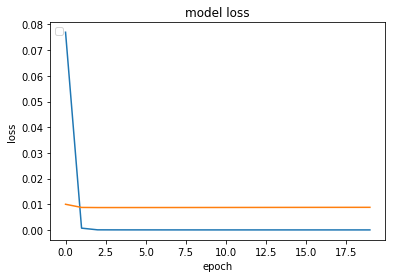

In [307]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])

plot_hist(hist)

## Recommender

In [295]:
df_movie = pd.read_csv('../data/ml-latest-small/movies.csv')
df_movie = df_movie.merge(df_movie_idx).set_index('movieId_idx')
df_movie.head()

,movieId,title,genres
movieId_idx,,,
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
481,2,Jumanji (1995),Adventure|Children|Fantasy
1,3,Grumpier Old Men (1995),Comedy|Romance
482,4,Waiting to Exhale (1995),Comedy|Drama|Romance
483,5,Father of the Bride Part II (1995),Comedy


In [296]:
id_view    = [1, 3114, 87222, 84944, 260, 1196, 1210, 2628, 79006, 2116, 7153, 5952]
idx_view   = df_movie_idx.set_index("movieId").loc[id_movies].values.reshape(-1)

In [297]:
df_movie[df_movie.movieId.isin(id_view)]

,movieId,title,genres
movieId_idx,,,
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
15,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
68,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
73,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
135,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy
171,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi
735,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
764,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
774,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy


In [298]:
data = np.ones(len(idx_view))
row  = np.zeros(len(idx_view))
col  = idx_movies

data_input = csr_matrix((data, (row, col)), shape=(1, input_size)).toarray()

In [299]:
data_pred  = model.predict(data_input)[0]

In [300]:
idx_pred  = list(range(len(df_movie)))
data_pred = model.predict(data_input)[0]
data_pred = dict(
                sorted(
                    zip(
                        list(idx_pred), 
                        list(data_pred[idx_pred].astype(float))
                    ), 
                key=lambda x: x[1],
            reverse=True)[:10])
data_pred            

{28: 0.999998927116394,
 16: 0.9999986886978149,
 7: 0.9999985694885254,
 987: 0.9999985694885254,
 232: 0.9999984502792358,
 166: 0.9999983310699463,
 34: 0.9999977350234985,
 478: 0.9999972581863403,
 20: 0.9999969005584717,
 1484: 0.9999968409538269}

In [301]:
df_movie.loc[list(data_pred.keys())]

,movieId,title,genres
movieId_idx,,,
28,527,Schindler's List (1993),Drama|War
16,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
7,110,Braveheart (1995),Action|Drama|War
987,1721,Titanic (1997),Drama|Romance
232,318,"Shawshank Redemption, The (1994)",Crime|Drama
166,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
34,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
478,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
20,356,Forrest Gump (1994),Comedy|Drama|Romance|War


In [302]:
idx_pred

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
